# Introduction

mff is a Python package developed for generating smooth forecasts for macroeconomic variables subject to pre-defined constraints. The purpose of the notebook is to walk through an example of using the main class from the package, called MFF, and taking a look at the main parts of the output which may be of interest to the user. This class is used for generated reconciled forecasts for single frequency data, i.e., all data is provided at one frequency (monthly/ quarterly/ yearly, etc.). MFF undertakes the following steps in order to genertate the final forecasts:

1. Parsing constraints
2. Estimating forecasts and residual covariance function
3. Reconciliation and smoothening

In this notebook, we will cover how to use the MFF class, and the output generated.

In [1]:
%load_ext autoreload
%autoreload 2

from sktime.datasets import load_macroeconomic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mff import utils
from mff import MFF

# Data and input formatting

We load in some synthetic data for this example. The data has to be provided as a Pandas DataFrame in a wide format: each row has one period's data, and each column has data for one variable. The row index must be of the type int or pd.PeriodIndex. All NaN values are treated as unknown points which have to be predicted. The dataframe must contain NaN for all periods which are to be forecasted for all variables.

In [2]:
df_example = load_macroeconomic()[['realgdp', 'realcons', 'realinv', 'realgovt']]
island_value = df_example.copy().iloc[-1,2]
df_example.iloc[-5:,1:3] = np.nan
df_example['residual'] = df_example['realgdp']-df_example['realcons']-df_example['realinv']-df_example['realgovt']
df_example.iloc[-1,2] = island_value
print('Historical data sample: \n\n', df_example.head())
print('\n\n Existing data for the forecast period: \n\n', df_example.tail(5))

Historical data sample: 

          realgdp  realcons  realinv  realgovt  residual
Period                                                 
1959Q1  2710.349    1707.4  286.898   470.045   246.006
1959Q2  2778.801    1733.7  310.859   481.301   252.941
1959Q3  2775.488    1751.8  289.226   491.260   243.202
1959Q4  2785.204    1753.7  299.356   484.052   248.096
1960Q1  2847.699    1770.5  331.722   462.199   283.278


 Existing data for the forecast period: 

           realgdp  realcons   realinv  realgovt  residual
Period                                                   
2008Q3  13324.600       NaN       NaN   991.551       NaN
2008Q4  13141.920       NaN       NaN  1007.273       NaN
2009Q1  12925.410       NaN       NaN   996.287       NaN
2009Q2  12901.504       NaN       NaN  1023.528       NaN
2009Q3  12990.341       NaN  1486.398  1044.088       NaN


The example data frame has five variables: `realgdp`, `realcons`, `realinv`, `realgovt` and `residual`. The `residual` variable is constructed as the difference of the sum of consumption, investment and government spending variables from the GDP, and can be though of as including the net exports of the country and other residual differences. `realcons`, `realinv` and `residual` have missing data from 2008Q3 onwards, while `realgovt` and `realgdp` have data for the entire forecast horizon. This is a situation where the forecaster has an idea of the GDP and Government spending for the forecast horizon, with no priors on the Consumption. `realinv` has one value in 2009Q3 after four NaN values, which we call an island from here on. This means that the forecaster believes that  `realinv` will reach a certain value at the end of the forecast period, while the forecasts for the previous four periods are not known a priori.

Once the data has been prepared in the required format, the next step is to define constraints. Constraints can be of two types: equality and inequality constrainsts. Constraints can be defined for one time period, or across all time periods using a wildcard. In this example, we assume that for all time periods, the following accounting identity holds:
`realgdp` = `realcons` + `realinv` + `realgovt` + `residual`.
This can be defined as follows:

In [3]:
equality_constraint = ['realgdp? - realcons? - realinv? - realgovt? - residual?']

The '?' in the above constraints act as the wildcard symbol,signifying that the identity holds over all periods of time. If instead one expects the constraint to only be binding in one period of time, say 2009Q1, the ? should be replaced by '2009Q1' for all variables in the constraint. Note that the constraint has to be input as a list, even when only one constraint is used.

With the data and constraints, we can proceed to estimating the models. The estimation happens in two steps: the first step involves generating unconstrained forecasts for all unknown variables at all forecast horizons. These unconstrained forecasts are then recolciled in the next step to make sure all constraints are satisfied and all island values are incorporated, with these forecasts smoothened over the entire horizon. Note that all forecasts are carried out using independent models, and different models may be used for estimating the same variable over multiple time horizons.

By default, a GridSearch method is used to find the best model for each variable and for each horizon. This GridSearch considers the following models:
- Naive Forecaster with drift strategy
- Naive forecaster with last strategy
- Naive forecaster with mean strategy
- Elastic Net Model
This can be initialised as follows:

In [4]:
BaseForecaster = utils.DefaultForecaster()

The user also has an option to define a different forecasting pipeline, with the models to be fit. This has to be derived from sktime's BaseForecaster class.

Now we have all the inputs required to be able to estimate the model. We assume there are no inequality constraints for this example; if there are any, these can be input in a similar way as the equality constraints using the `ineq_constraints_with_wildcard` argument as well.

# Model fitting- Single frequency data

In [5]:
mff_model = MFF(df = df_example, 
            forecaster = BaseForecaster, 
            constraints_with_wildcard = equality_constraint, 
            ineq_constraints_with_wildcard = [], 
            parallelize = True)

mff_model.fit()

Dask filled 15 out-of-sample cells: 12.642 seconds
Dask filled 75 in-sample cells: 15.322 seconds


,realgdp,realcons,realinv,realgovt,residual
Period,,,,,
1959Q1,2710.349,1707.400000,286.898000,470.045,246.006000
1959Q2,2778.801,1733.700000,310.859000,481.301,252.941000
1959Q3,2775.488,1751.800000,289.226000,491.260,243.202000
1959Q4,2785.204,1753.700000,299.356000,484.052,248.096000
1960Q1,2847.699,1770.500000,331.722000,462.199,283.278000
...,...,...,...,...,...
2008Q3,13324.600,9333.081496,2050.047440,991.551,949.920064
2008Q4,13141.920,9420.409014,1900.771423,1007.273,813.466563
2009Q1,12925.410,9509.252236,1757.776801,996.287,662.093963


The `fit()` method carries out the following steps
- Parse through constraints and convert them into matrix form.
- Generate first step forecasts using the model defined in BaseForecaster.
- Calculate the smoothing parameters to be used.
- Reconcile first step forecasts to all constraints, and ensure the forecasts are smooth.

The full dataframe with first step forecasts fill in are stored as df1 in the mff object, and the models used for each forecast are stored in a dataframe named df1_models. These can be accessed as follows: 

In [6]:
df_first_step = mff_model.df1
print( 'First step forecasts: \n\n',  df_first_step[['realcons', 'realinv', 'residual']].tail(5))

df_first_step_models = mff_model.df1_model
print('First step models: \n\n', df_first_step_models[['realcons', 'realinv', 'residual']].tail(5))

First step forecasts: 

         realcons   realinv    residual
Period                                
2008Q3  9370.725  2082.886  1033.90225
2008Q4  9391.850  2082.886  1076.79750
2009Q1  9412.975  2082.886  1119.69275
2009Q2  9434.100  2082.886  1162.58800
2009Q3  9455.225  2082.886  1205.48325
First step models: 

                                                  realcons  \
Period                                                      
2008Q3  ForecastingGridSearchCV(backend='dask', cv=Exp...   
2008Q4  ForecastingGridSearchCV(backend='dask', cv=Exp...   
2009Q1  ForecastingGridSearchCV(backend='dask', cv=Exp...   
2009Q2  ForecastingGridSearchCV(backend='dask', cv=Exp...   
2009Q3  ForecastingGridSearchCV(backend='dask', cv=Exp...   

                                                  realinv  \
Period                                                      
2008Q3  ForecastingGridSearchCV(backend='dask', cv=Exp...   
2008Q4  ForecastingGridSearchCV(backend='dask', cv=Exp...   
2009Q1  

Note that there was an island value for `realinv` at time 2009Q3. The first step forecast for `realinv` for that period is not the same, since reconciliation has not taken place yet. Similarly, the accounting identity also does not hold for any time period here. These will be taken care of in the reconciliation step.

It is useful to look at the matrix of constraints used. These are converted to matrix form, and are in the form 
$C Y = d$, where $C$ and $d$ are matrices of constraints, as in equation (1) of Ando (2024).

In [7]:
C_matrix = mff_model.C
d_matrix = mff_model.d

print('C matrix is: \n \n', C_matrix)
print('\n \n d matrix is: \n \n', d_matrix)

C matrix is: 
 
                                                    realcons                \
Period                                               2008Q3 2008Q4 2009Q1   
(realinv, 2009Q3)                                       0.0    0.0    0.0   
realgdp_2008Q3 - realcons_2008Q3 - realinv_2008...     -1.0    0.0    0.0   
realgdp_2008Q4 - realcons_2008Q4 - realinv_2008...      0.0   -1.0    0.0   
realgdp_2009Q1 - realcons_2009Q1 - realinv_2009...      0.0    0.0   -1.0   
realgdp_2009Q2 - realcons_2009Q2 - realinv_2009...      0.0    0.0    0.0   
realgdp_2009Q3 - realcons_2009Q3 - realinv_2009...      0.0    0.0    0.0   

                                                                 realinv  \
Period                                             2009Q2 2009Q3  2008Q3   
(realinv, 2009Q3)                                     0.0    0.0     0.0   
realgdp_2008Q3 - realcons_2008Q3 - realinv_2008...    0.0    0.0    -1.0   
realgdp_2008Q4 - realcons_2008Q4 - realinv_2008...    0.0    0

The parameters which are used for the reconciliation step are also stored in mff. These are stored as `W`, `Phi` and `smoothness`. W is the weight matrix which is derived from the errors of in-sample forecasting, and `Phi` is a symmetric block-diagonal smoothness matrix, as defined in Ando (2024). `smoothness` contains the smoothness parameters ($\lambda$) used in the `Phi` matrix, which are empirically estimated by default.   

In [8]:
W = mff_model.W
Phi = mff_model.Phi
smoothness = mff_model.smoothness

print('Wrighting matrix (W) is: \n\n', W)
print('Smoothing matrix (Phi) is: \n\n', Phi)
print('smoothness parameters are: \n\n', smoothness)

Wrighting matrix (W) is: 

                     realcons                                         \
Period                2008Q3       2008Q4       2009Q1       2009Q2   
         Period                                                       
realcons 2008Q3  1502.675228    57.228541   -59.671415   -34.643382   
         2008Q4    57.228541  1534.123697   198.733682   305.288098   
         2009Q1   -59.671415   198.733682  1880.727408   956.215021   
         2009Q2   -34.643382   305.288098   956.215021  3167.958422   
         2009Q3  -174.274054   404.553571  1225.604956  2265.364772   
realinv  2008Q3  -392.054974  -422.997493  -107.449457   -88.384187   
         2008Q4  -190.409262  -636.030627  -649.278670  -943.368512   
         2009Q1     6.842762  -431.552492  -821.477580 -1312.420165   
         2009Q2  -145.120799  -256.856544  -624.719535 -1211.478060   
         2009Q3  -322.736350  -294.794203  -299.302082  -614.367661   
residual 2008Q3   126.526296  -135.967261  -480.1

Finally, the input dataframe with reconciled and smooth forecasts filled in can be retreived as the dataframe `df2` from the mff object.

In [9]:
df_reconciled = mff_model.df2

print('Values over the forecast horizon are: \n \n', df_reconciled[-5:])

Values over the forecast horizon are: 
 
           realgdp     realcons      realinv  realgovt    residual
Period                                                           
2008Q3  13324.600  9333.081496  2050.047440   991.551  949.920064
2008Q4  13141.920  9420.409014  1900.771423  1007.273  813.466563
2009Q1  12925.410  9509.252236  1757.776801   996.287  662.093963
2009Q2  12901.504  9600.582565  1621.776245  1023.528  655.617190
2009Q3  12990.341  9693.660428  1486.398000  1044.088  766.194572


Looking at the forecasts for `realinv` in the first and final steps, it becomes clear that after the reconciliation step, the final forecasts match the island value provided, and the intermediate horizon forecasts are also adjusted in a way to keep the forecast path smooth.

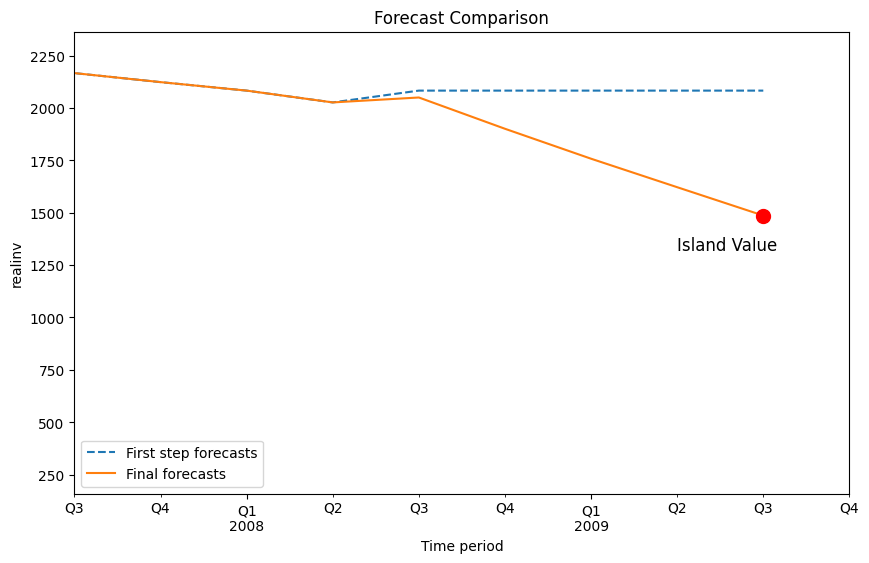

In [10]:
fig, ax = plt.subplots(figsize=(10, 6)) 

df_first_step['realinv'].plot(ax=ax, label='First step forecasts', linestyle = '--')
df_reconciled['realinv'].plot(ax=ax, label='Final forecasts')

ax.plot(df_example.index[-1], df_example['realinv'].iloc[-1], 'o', markersize=10, color='red')
ax.text(df_example.index[-1] - 1, df_example['realinv'].iloc[-1]-100, 'Island Value', fontsize = 12, verticalalignment = 'top')

ax.set_xlabel('Time period')  
ax.set_ylabel('realinv')  
ax.set_title('Forecast Comparison')  
ax.legend(loc = 'lower left')

ax_xlastvalue = df_reconciled.index.max() + 1
ax.set_xlim(['2007-Q3', '2009-Q4'])

df_reconciled['slack'] = round(df_reconciled['realgdp'] - df_reconciled[['realcons', 'realinv', 'realgovt', 'residual']].sum(axis = 1),2)
plt.show()

Recall that the constraint has been defined as 
`realgdp` = `realcons` + `realinv` + `realgovt` + `resid`
In the case of unconstrained first step forecasts, the difference between the left and right hand sides of the equation is not necessarily zero, while it must be zero by construction for the reconciled forecasts. This can also be empiriically seen in the following graph.

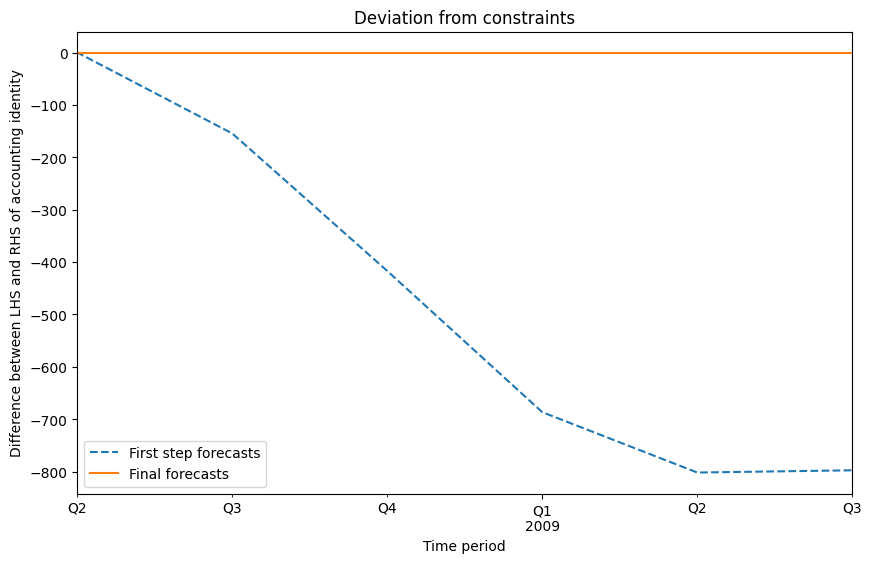

In [11]:

df_first_step['slack'] = round(df_first_step['realgdp'] - df_first_step[['realcons', 'realinv', 'realgovt', 'residual']].sum(axis = 1),2)
df_reconciled['slack'] = round(df_reconciled['realgdp'] - df_reconciled[['realcons', 'realinv', 'realgovt', 'residual']].sum(axis = 1),2)

fig, ax = plt.subplots(figsize=(10, 6)) 

df_first_step['slack'].plot(ax=ax, label='First step forecasts', linestyle = '--')
df_reconciled['slack'].plot(ax=ax, label='Final forecasts')


ax.set_xlabel('Time period')  
ax.set_ylabel('Difference between LHS and RHS of accounting identity')  
ax.set_title('Deviation from constraints')  
ax.legend(loc = 'lower left')

ax_xlastvalue = df_reconciled.index.max() + 1
ax.set_xlim(['2008-Q2', '2009-Q3'])

plt.show()